## Training and validation of goggle quick-draw drawings

We train using compressed simplified drawings that are converte to images during training


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from code import *
from graphics import *

import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import gc

In [4]:
from core_ai.lib.modelmanager import *
from core_ai.lib.model import *
from core_ai.lib.data import *
from core_ai.lib.optimizers import *
#from core_ai.lib.callbacks import *
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time


In [5]:
#for now we want a reproducible randomization
random.seed(42) # Set the random number generator to a fixed sequence.

In [6]:
data             = Path("../data/google_quick_draw")
data_prepared    = data/"train"
data_prepared.mkdir(exist_ok=True)

vocab_file       = data_prepared/"vocab.json"
train_ds_file    = data_prepared/"train_dataset.pkl"
valid_ds_file    = data_prepared/"valid_dataset.pkl"

In [15]:
compressed_drawings = True
valid_ratio         = 0.1
size, line_width    = 28, 1
linetype            = cv2.LINE_8 #cv2.LINE_AA
x_mean_28x28_lw1    = 0.039329988241740325
x_sd_28x28_lw1      = 0.1442951068113638
qd2norm_image       = drawing2image_nomalized( size, line_width, 
                                               linetype, compressed_drawings,
                                               x_mean_28x28_lw1, x_sd_28x28_lw1 )

In [8]:
%%time
with vocab_file.open('r') as fp:
    vocab = json.load(fp)
train_ds, valid_ds = readDatasets(train_ds_file, valid_ds_file)

#normalize x (the image) using qd2norm_image
train_ds = NormalizedDataset(train_ds.x, train_ds.y, qd2norm_image )
valid_ds = NormalizedDataset(valid_ds.x, valid_ds.y, qd2norm_image )

CPU times: user 13.6 s, sys: 23.3 s, total: 36.9 s
Wall time: 41.6 s


In [17]:
#uncomment if you need to calculate menn and sd for you drawing parameters
calc_sd_mean = False
if calc_sd_mean :
    gd2image = quick_draw2image(size, line_width, linetype, compressed_drawings )
    x_mean = calc_x_mean( train_ds, gd2image )
    print(x_mean)
    x_sd   = calc_x_sd( train_sd, x_mean, gd2image )
    gc.collect()
    print(x_sd)

In [18]:
n_train  = 34000
n_valid  = 3400
ix_train = np.random.randint(0,len(train_ds.x),n_train)
ix_valid = np.random.randint(0,len(valid_ds.x),n_valid)

train_ds.x, train_ds.y = train_ds.x[ix_train], train_ds.y[ix_train]
valid_ds.x, valid_ds.y = valid_ds.x[ix_valid], valid_ds.y[ix_valid]
ix_train = ix_valid = None
gc.collect()
print(f"training dataset  : {len(train_ds.x), len(train_ds.x) }") 
print(f"validation dataset: {len(valid_ds.x), len(valid_ds.x) }") 

training dataset  : (34000, 34000)
validation dataset: (3400, 3400)


reading and converting compressed drawings to images
plot images : 64


230

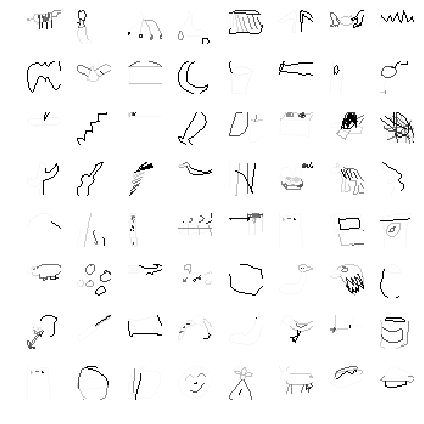

In [19]:
draw_images_from_dataset(train_ds, size, line_width, linetype, nb=64, nrows=8,
                         compressed_drawings=True, figsize=(6, 6))
gc.collect()

In [20]:
nh,bs              = 50,340
train_dl, valid_dl = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                       DataLoader(valid_ds,  batch_size=bs*2) )
data               = DataBunch( train_dl, valid_dl, c_in=1, c_out=len(vocab) )
print(f"training and validation batches: {len(data.train_dl)}, {len(data.valid_dl)}")

training and validation batches: 100, 5


In [21]:
xb, _ = next(iter(train_dl))

<class 'torch.Tensor'> torch.Size([340, 1, 28, 28]) tensor(-0.0031) tensor(0.9969)


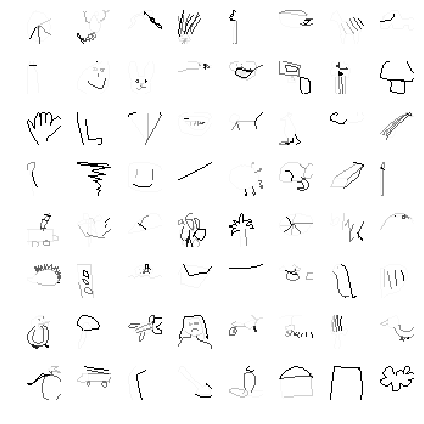

In [22]:
print( type(xb), xb.shape, xb.mean(), xb.std() )
plot_images(xb.view(xb.shape[0],28,28).data.numpy(), cmap=cm.Greys, max_rows_cols=8, figsize=(6, 6) )

In [23]:
# average loss pr input sample at iteration 0
initial_loss = -np.log( 1.0/len(vocab) ) 
print(f"For equal distribution of cases pr class:\ninitial loss:    {initial_loss}\ninitial accuracy {1.0/len(vocab)}")


For equal distribution of cases pr class:
initial loss:    5.8289456176102075
initial accuracy 0.0029411764705882353


In [49]:
def print_weight_bias(mm:CnnModelManager):
    modules = mm.find_modules(lambda m: not isinstance(m, nn.Sequential))
    with torch.no_grad(): 
        for m in modules:
            print(f"\nmodule:{type(m)}")
            if getattr(m, 'bias', None) is not None: 
                print(f"Bias: {m.bias.shape} m:{m.bias.mean():.3f}, std:{m.bias.std():.3f}, max_abs:{m.bias.abs().max():.3f}") 
            if getattr(m, 'weight', None) is not None: 
                print(f"Weight:{m.weight.shape} m:{m.weight.mean():.3f}, std:{m.weight.std():.3f}, max_abs:{m.weight.abs().max():.3f}")


In [25]:
class SimpleModel(nn.Sequential):
    @classmethod
    def create(cls, filters_pr_layer,  input_features,  output_features, layer, **kwargs):
        in2hidden = [   nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=3//2, bias=False),
                        #nn.BatchNorm2d(1),
                        ReLUOffset()
                        #torch.nn.ReLU(inplace=True)
                    ]
        #hidden2out =  [Lambda(flatten), nn.Linear(4*14*14, output_features) ]
        hidden2out =  [Lambda(flatten), nn.Linear(1*14*14, output_features) ]
        all_layers = in2hidden + hidden2out
        return SimpleModel(*all_layers)
    def initialize(model, uniform:bool=False, a=0):
        modules = find_submodules(model, lambda m: not isinstance(m, nn.Sequential))
        for m in modules:
            if isinstance(m, (nn.Conv2d) ):
                init.kaiming_normal_(m.weight, nonlinearity="relu")
                if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, mean=0., std=1./m.weight.shape[1])
                m.bias.data.zero_()


In [26]:
#layers_sizes = [8,16,32,32]
bw_view   = view_tfm(1,28,28)
layers_sizes = []
loss_func    = F.cross_entropy
sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = bw_view), 
#                partial(MixUp,α=0.2),
#                LR_Finder,
                Recorder, 
                partial(AvgStatsCallback,[accuracy]),
                ProgressCallback
               ]


In [27]:
#loss_func=LabelSmoothingCrossEntropy()
loss_func=F.cross_entropy

#layer = partial( conv_layer, stride=2, bn=False, zero_bn=False, act=GeneralRelu )
layer = partial( conv_layer, stride=2, bn=False, zero_bn=False, act=partial(torch.nn.ReLU,inplace=True) )
print(f"initial loss:{math.log(1/340)}")

initial loss:-5.8289456176102075


In [104]:
# loss with bias initialized to zero => the first two epochs are used to initialize 
#the bias
               
#why do i have to create a new learner   # calling mm.getFirstbatch creates problems
#opt   = SGD(sched,max_lr=0.5)
opt   = Adam(sched,max_lr=0.01, moms=(0.85,0.95), max_wd = 0.0)#1e-6)

#model = SimpleModel.create(layers_sizes, data.c_in, data.c_out, layer=layer)
model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out)() #xresnet50
mm    = CnnModelManager( model )
model.initialize(uniform=False)

print("\nWeight and bias")
print_weight_bias(mm)

print("\nModel summary")
mm.summary(xb, print_mod=False)


print("\nLearn")
learn = Learner( mm.model, data, loss_func=loss_func)
%time learn.fit(100, opt=opt, cb_funcs=cbfs)


Weight and bias

module:<class 'torch.nn.modules.conv.Conv2d'>
Weight:torch.Size([16, 1, 3, 3]) m:0.012, std:0.497, max_abs:1.202

module:<class 'core_ai.lib.model.ReLUOffset'>

module:<class 'torch.nn.modules.pooling.AvgPool2d'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>

module:<class 'core_ai.lib.model.Flatten'>

module:<class 'torch.nn.modules.linear.Linear'>
Bias: torch.Size([340]) m:0.000, std:0.000, max_abs:0.000
Weight:torch.Size([340, 32]) m:-0.003, std:0.249, max_abs:1.034

Model summary
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([340, 16, 14, 14])
<class 'core_ai.lib.model.ReLUOffset'> torch.Size([340, 16, 14, 14])
<class 'torch.nn.modules.pooling.AvgPool2d'> torch.Size([340, 16, 7, 7

84        0.701016    0.822059        9.154240    0.146176        00:11     
85        0.711458    0.816471        9.167686    0.142941        00:11     
86        0.683436    0.823176        9.340676    0.148235        00:11     
87        0.656557    0.831176        9.681368    0.140000        00:11     
88        0.652669    0.831235        9.571868    0.146176        00:12     
89        0.620748    0.841382        9.618020    0.130294        00:12     
90        0.601878    0.845500        10.026140   0.137941        00:11     
91        0.606885    0.843971        9.964112    0.152941        00:10     
92        0.598675    0.845265        10.268290   0.142647        00:10     
93        0.576037    0.852618        10.226628   0.151765        00:10     
94        0.561119    0.855882        10.390353   0.131176        00:10     
95        0.579815    0.847382        10.507916   0.140294        00:10     
96        0.529401    0.863147        10.675856   0.143235        00:10     

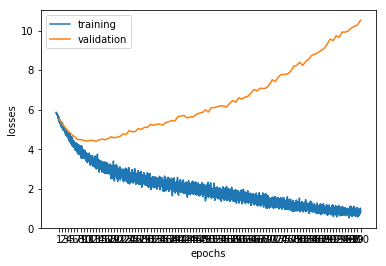

(None, None)

In [102]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

In [103]:
print_weight_bias(mm)
#1/math.sqrt(1*3*3)*2/math.sqrt(12), 1/math.sqrt(196)*2/math.sqrt(12)


module:<class 'torch.nn.modules.conv.Conv2d'>
Weight:torch.Size([16, 1, 3, 3]) m:-0.069, std:0.519, max_abs:1.684

module:<class 'torch.nn.modules.activation.ReLU'>

module:<class 'torch.nn.modules.pooling.AvgPool2d'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'core_ai.lib.model.ResBlock'>

module:<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>

module:<class 'core_ai.lib.model.Flatten'>

module:<class 'torch.nn.modules.linear.Linear'>
Bias: torch.Size([340]) m:-0.013, std:0.605, max_abs:1.837
Weight:torch.Size([340, 32]) m:-0.230, std:0.614, max_abs:4.721
